2do
- by weeks:
    - select important news - compare vs Kulbaka
    - evaluate pos-neg - compare vs Kulbaka (incl those not selected on prev stage)

### constants and imports

In [1]:
# check env - google colab or local
import sys

def check_environment():
    if 'google.colab' in sys.modules:
        # Running in Google Colab
        return "Google Colab"

    if hasattr(sys, 'prefix'):
        if sys.prefix.startswith('/usr/local'):
            # Running in a Colab-like environment (could be Colab or another cloud environment)
            return "Colab-like environment"
        else:
            # Running in a local environment
            return "Local environment"

    # Default to local environment if checks are inconclusive
    return "Local environment"

In [2]:
# set paths and install packages depending on the environment

if check_environment() == 'Google Colab':
    !pip install --quiet sentence_transformers transformers sumy nltk gnews newspaper3k

    from google.colab import drive
    drive.mount('/content/drive')

    path = '/content/drive/MyDrive/Colab Notebooks/other/econ_news(Kulbaka)/'
    data_path = path+'data/'
    model_path = path+'news_models/'

else:
    data_path = '../data/'
    model_path = '../news_models/'

In [3]:
import pandas as pd
import numpy as np
import pickle

from tqdm.notebook import tqdm_notebook

### Create embeddings

this section is performed in Colab to leverage T4 and save local disk space on model

In [ ]:
!pip install --quiet sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('intfloat/multilingual-e5-large')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/Colab Notebooks/other/econ_news(Kulbaka)/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv(data_path+'rus_econ_news_full.csv')
df.shape

(5613, 8)

In [ ]:
texts = df['summary'].to_list()
embeddings = model.encode(texts, show_progress_bar=True)
df["emb_e5"] = [row.reshape(-1) for row in embeddings]

Batches:   0%|          | 0/176 [00:00<?, ?it/s]

In [ ]:
np.save(data_path+"rus_econ_news_full_embeds.npy", embeddings)

# select important news

In [ ]:
df = pd.read_csv(data_path+'rus_econ_news_full.csv')
df.shape

(5613, 8)

In [ ]:
# convert to date
df['date'] = pd.to_datetime(df['published date'])
# calculate week number
df['week'] = df['date'].dt.isocalendar().week

In [ ]:
df['date'].min(), df['date'].max()

(Timestamp('2023-07-31 07:00:00'), Timestamp('2023-10-10 06:54:44'))

In [ ]:
df.head(3)

,title,description,published date,url,publisher,full_article,summary,date
0,Экономика России: финансист Станислав Краснояр...,Экономика России: финансист Станислав Краснояр...,"Tue, 01 Aug 2023 07:00:00 GMT",https://news.google.com/rss/articles/CBMiOGh0d...,"{'href': 'https://www.chita.ru', 'title': 'Чит...",Экономика России: финансист Станислав Краснояр...,Экономика России: финансист Станислав Краснояр...,2023-08-01 07:00:00
1,Дело спроса: российская экономика пошла в рост...,Дело спроса: российская экономика пошла в рост...,"Mon, 31 Jul 2023 07:00:00 GMT",https://news.google.com/rss/articles/CBMiVmh0d...,"{'href': 'https://eadaily.com', 'title': 'EADa...",Российская экономика во втором квартале 2023 г...,Российская экономика во втором квартале 2023 г...,2023-07-31 07:00:00
2,Новости - Новости - Правительство России,Новости Новости - Правительство России,"Mon, 31 Jul 2023 07:00:00 GMT",https://news.google.com/rss/articles/CBMiIGh0d...,"{'href': 'http://government.ru', 'title': 'Нов...",Пресс-подход Юрия Трутнева по итогам совещания...,Заместитель Председателя Правительства – полно...,2023-07-31 07:00:00


In [ ]:
embeddings = np.load(data_path+"rus_econ_news_full_embeds.npy")

In [ ]:
# predict the importance
clf = pickle.load(open(model_path+'news_importance_model.pkl', 'rb'))
df['prob_import'] = clf.predict_proba(embeddings)[:,1]
# mark the news with prob > 0.38 as important
df['important'] = np.where(df['prob_import'] > 0.38, 1, 0)

In [ ]:
# print the number of important news of the total
print(f"Number of important news: {df.important.sum()} of total {df.important.count()}")

Number of important news: 315 of total 5613


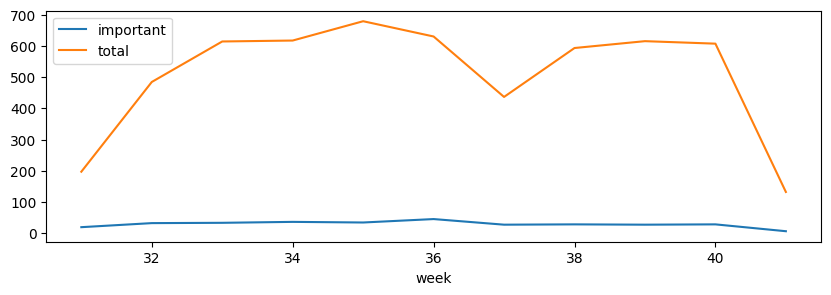

In [ ]:
import matplotlib.pyplot as plt

# important news vs total by week
df.groupby('week')['important'].agg(['sum', 'count']).plot(figsize=(10,3))
# change legend names
plt.legend(['important', 'total'])

In [ ]:
df.groupby('week')['important'].agg(['sum', 'count'])

,sum,count
week,,
31,19,197
32,32,485
33,33,615
34,36,618
35,34,680
36,45,631
37,27,437
38,28,594
39,27,616


In [ ]:
df.to_csv(data_path+'rus_econ_news_full.csv', index=False)

# Evaluate news (pos-neg)

TO DO
- load news important by model (1)
- load news important by Kulbaka (2)
- calc pos - neg
- compare (1) vs total by Kulbaka
- compare (2) by individual news by Kulbaka

In [5]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli", device=0)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [6]:
df = pd.read_csv(data_path+'rus_econ_news_full.csv')
df_imp = df[df.important==1]

df_kulb = pd.read_csv(data_path+'important_news_Kulbaka.csv', sep=';')

In [7]:
# NLI fr imprt news. Candidate labels can be adjusted
bad_news = ['плохо для российской экономики', 'российская экономика ухудшается', 'негативная новость для экономики России']
good_news = ['хорошо для российской экономики', 'российская экономика  улучшается', 'позитивная новость для экономики России']
candidate_labels = bad_news + good_news
n_labels = len(candidate_labels)

for id, row in tqdm_notebook(df_imp.iterrows(), total = df_imp.shape[0]):
    output = classifier(row['summary'], candidate_labels, multi_label=True)
    for i_label in range(n_labels):
      df_imp.at[id, output['labels'][i_label]] = output['scores'][i_label]

  0%|          | 0/315 [00:00<?, ?it/s]

<ipython-input-7-2097c081a75e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imp.at[id, output['labels'][i_label]] = output['scores'][i_label]
<ipython-input-7-2097c081a75e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imp.at[id, output['labels'][i_label]] = output['scores'][i_label]
<ipython-input-7-2097c081a75e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [8]:
df_imp['bad_news'] = df_imp[bad_news].mean(axis=1)
df_imp['good_news'] = df_imp[good_news].mean(axis=1)

<ipython-input-8-106fd17749ed>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imp['bad_news'] = df_imp[bad_news].mean(axis=1)
<ipython-input-8-106fd17749ed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imp['good_news'] = df_imp[good_news].mean(axis=1)


In [12]:
# NLI fr imprt news. Candidate labels can be adjusted
bad_news = ['плохо для российской экономики', 'российская экономика ухудшается', 'негативная новость для экономики России']
good_news = ['хорошо для российской экономики', 'российская экономика  улучшается', 'позитивная новость для экономики России']
candidate_labels = bad_news + good_news
n_labels = len(candidate_labels)

for id, row in tqdm_notebook(df_kulb.iterrows(), total = df_kulb.shape[0]):
    output = classifier(row['Новость'], candidate_labels, multi_label=True)
    for i_label in range(n_labels):
      df_kulb.at[id, output['labels'][i_label]] = output['scores'][i_label]

  0%|          | 0/110 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [13]:
df_kulb['bad_news'] = df_kulb[bad_news].mean(axis=1)
df_kulb['good_news'] = df_kulb[good_news].mean(axis=1)

In [9]:
df_imp.to_csv(data_path+'rus_econ_news_important.csv')
df_kulb.to_csv(data_path+'important_news_Kulbaka.csv')

## Results analyssi

### compare Kulbaka news - NLI vs Kulbaka

In [34]:
df_imp = pd.read_csv(data_path+'rus_econ_news_important.csv',)
df_kulb = pd.read_csv(data_path+'important_news_Kulbaka.csv')

In [37]:
df_kulb[['направление', 'bad_news', 'good_news']].corr()

,направление,bad_news,good_news
направление,1.000000,-0.618048,0.654203
bad_news,-0.618048,1.000000,-0.749610
good_news,0.654203,-0.749610,1.000000


In [38]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [40]:
class_labels = ['bad_news', 'good_news']
for label in class_labels:
    df_kulb[['bad_news_prob', 'good_news_prob']] = df_kulb.apply(lambda row: softmax(row[class_labels].values.tolist()), axis=1, result_type='expand')

In [41]:
df_kulb['направление_pred'] = (df_kulb['good_news_prob']-0.5)*10

Text(0.5, 1.0, 'Correlation: 0.683')

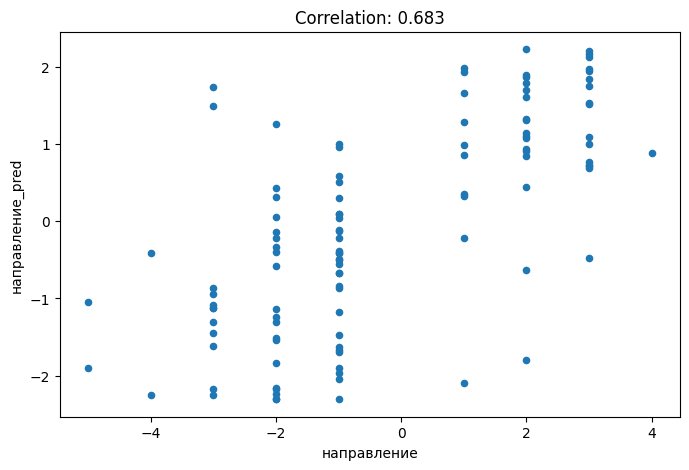

In [46]:
import matplotlib.pyplot as plt
# scatter plot
correl = df_kulb[['направление','направление_pred']].corr().iloc[0,1]
df_kulb[['направление','направление_pred']].plot.scatter(x='направление', y='направление_pred', figsize=(8,5))
plt.title(f"Correlation: {round(correl, 3)}")

check whn prediction is opposite to true value

In [61]:
df_kulb.columns

Index(['Unnamed: 0', 'week', 'N', 'Новость', 'важность', 'направление',
       'источник', 'российская экономика  улучшается',
       'позитивная новость для экономики России',
       'хорошо для российской экономики', 'плохо для российской экономики',
       'негативная новость для экономики России',
       'российская экономика ухудшается', 'bad_news', 'good_news',
       'bad_news_prob', 'good_news_prob', 'направление_pred'],
      dtype='object')

<Axes: ylabel='Frequency'>

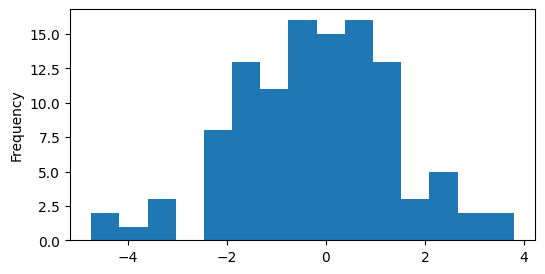

In [69]:
df_kulb['направление_diff'] = df_kulb['направление'] - df_kulb['направление_pred']
df_kulb['направление_diff'].plot.hist(bins=15, figsize=(6,3))

In [68]:
df_kulb['направление_diff'].describe()

count    110.000000
mean      -0.193217
std        1.618717
min       -4.742808
25%       -1.249009
50%       -0.159335
75%        0.884409
max        3.795145
Name: направление_diff, dtype: float64

In [70]:
# replace dot with comma while copying to excel
df_kulb[abs(df_kulb['направление_diff']) > 2][['Новость', 'направление_pred', 'направление']].to_clipboard(excel=True)

,Новость,направление_pred,направление
4,6 октября. INTERFAX.RU - Российский рубль заме...,1.001089,-1
5,В сентябре в Башкирии на 52 процента по сравне...,1.498821,-3
14,Первый взнос по льготной ипотеке Правительство...,0.317731,-2
18,15 сентября биржевые цены на бензин АИ-92 обно...,0.428179,-2
25,За 2022 год количество сотрудников IT-компаний...,-0.404316,-4
30,Прирост ВВП по итогам 2023 года оценивается в ...,0.883963,4
42,Организация экономического сотрудничества и ра...,-0.470119,3
43,"Доходы от нефти и газа в России, на которые пр...",0.691766,3
45,В следующем году российские власти планируют у...,-0.946857,-3
46,Уровень безработицы в Карелии снизился до реко...,1.742808,-3


### compare weekly evaluation by Model vs Kulbaka

first, correct the week column format` in Kulbaka data

In [81]:
# Define a function to convert date range strings to date objects
def convert_date_range(date_range_string, year):
    start_date_str, end_date_str = date_range_string.split('-')
    start_date = pd.to_datetime(f'{year}-{start_date_str}', format='%Y-%d.%m')
    end_date = pd.to_datetime(f'{year}-{end_date_str}', format='%Y-%d.%m')
    return start_date, end_date

# Apply the function to the 'date_range' column
year = 2023  # Change this to the appropriate year
df_kulb[['start_date', 'end_date']] = df_kulb['week'].apply(lambda x: pd.Series(convert_date_range(x, year)))

In [82]:
df_kulb['week_orig'] = df_kulb['week']
df_kulb['week'] = df_kulb['start_date'].dt.isocalendar().week

<Axes: xlabel='week'>

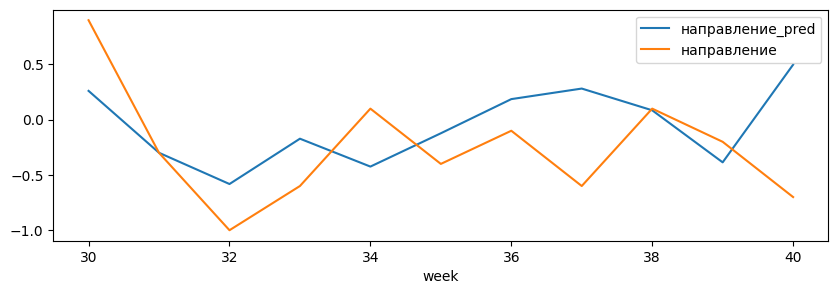

In [83]:
df_kulb.groupby('week')[['направление_pred', 'направление']].mean().plot(figsize=(10,3))

In [26]:
df_imp_weekly = df_imp.groupby('week')[['bad_news',	'good_news']].mean()
df_kulb_weekly = df_kulb.groupby('week')[['bad_news',	'good_news']].mean()

In [29]:
pd.concat([df_imp_weekly, df_kulb_weekly], axis=1, join='outer')

,bad_news,good_news,bad_news,good_news
week,,,,
31,0.266308,0.373461,0.426942,0.296571
32,0.207939,0.435034,0.512751,0.270999
33,0.374725,0.186819,0.326825,0.260710
34,0.249264,0.445323,0.397499,0.219204
35,0.294239,0.316464,0.362822,0.302600
36,0.330955,0.227310,0.354605,0.432089
37,0.448147,0.215947,0.241657,0.360057
38,0.405142,0.270554,0.320310,0.357724
39,0.356178,0.399428,0.421798,0.260829


In [91]:
df_kulb.to_excel(data_path+'important_news_Kulbaka.xlsx', index=False)
df_imp.to_excel(data_path+'rus_econ_news_important.xlsx', index=False)

#### compare predictions

In [75]:
class_labels = ['bad_news', 'good_news']
for label in class_labels:
    df_imp[['bad_news_prob', 'good_news_prob']] = df_imp.apply(lambda row: softmax(row[class_labels].values.tolist()), axis=1, result_type='expand')

In [76]:
df_imp['направление_pred'] = (df_imp['good_news_prob']-0.5)*10

In [84]:
df_imp_pred_weekly = df_imp.groupby('week')['направление_pred'].mean()
df_kulb_pred_weekly = df_kulb.groupby('week')[['направление_pred', 'направление']].mean()

In [87]:
# set column names: pred_full, pred_kulb, true_kulb
df_imp_pred_weekly.name = 'pred_full'
df_kulb_pred_weekly.columns = ['pred_kulb', 'true_kulb']
pd.concat([df_imp_pred_weekly, df_kulb_pred_weekly], axis=1, join='outer')

,pred_full,pred_kulb,true_kulb
week,,,
31,0.256218,-0.299371,-0.3
32,0.535555,-0.581971,-1.0
33,-0.454454,-0.171887,-0.6
34,0.464663,-0.424265,0.1
35,0.052721,-0.122823,-0.4
36,-0.246241,0.186212,-0.1
37,-0.555494,0.281685,-0.6
38,-0.311476,0.084969,0.1
39,0.100778,-0.385797,-0.2


In [89]:
pd.concat([df_imp_pred_weekly, df_kulb_pred_weekly], axis=1, join='outer').corr()

,pred_full,pred_kulb,true_kulb
pred_full,1.000000,-0.656127,-0.069068
pred_kulb,-0.656127,1.000000,0.222090
true_kulb,-0.069068,0.222090,1.000000


# Last news
- load news
- select important ones (via model)
- check positive / negative
Need to run in Colab due to inet speed, gpu (embeds, nli)

## Load news (incl full texts)

In [ ]:
from gnews import GNews
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
import nltk
from sumy.summarizers.lsa import LsaSummarizer

import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

/Users/alexbadin/miniconda3/envs/scraping/lib/python3.12/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.17) or chardet (5.2.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [ ]:
# download news day by day (due to 100 limit) via combining dictionaries
start_date = '2023-10-03'
end_date = '2023-10-10'

rus_econ_news = []
for date in tqdm(pd.date_range(start_date, end_date)):
    google_news = GNews(language='ru', country='RU', start_date=date - pd.Timedelta(days=1), end_date=date)
    rus_econ_news += google_news.get_news('Экономика России')

100%|██████████| 71/71 [39:42<00:00, 33.55s/it]  


In [ ]:
# iterate over the news
for news in tqdm(rus_econ_news):
    try:
        # get the full article
        news['full_article'] = google_news.get_full_article(news['url']).text
    except:
        news['full_article'] = ''

  0%|          | 0/89 [00:00<?, ?it/s]

100%|██████████| 89/89 [02:18<00:00,  1.55s/it]


In [ ]:
summarizer_2 = LsaSummarizer()
nltk.download('punkt')

def summarize(text, language="english", sentences_count=5):
    parser = PlaintextParser.from_string(text, Tokenizer(language))
    summarizer = LsaSummarizer()
    summary = summarizer(parser.document, sentences_count)
    return ' '.join([str(sentence) for sentence in summary])

[nltk_data] Downloading package punkt to /Users/alexbadin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# summarize the news (select 2 most important sentences)
for news in tqdm(rus_econ_news):
    try:
        news['summary'] = summarize(news['full_article'], language="russian", sentences_count=2)
    except:
        news['summary'] = ''

100%|██████████| 89/89 [00:05<00:00, 17.76it/s]


In [ ]:
today_news = pd.DataFrame(rus_econ_news)
# replace missing articles with descriptions
today_news['full_article'].fillna(today_news['description'], inplace=True)
today_news['summary'].fillna(today_news['description'], inplace=True)

In [ ]:
# convert to date
df['date'] = pd.to_datetime(df['published date'])
# calculate week number
df['week'] = df['date'].dt.isocalendar().week
# check the date range
df['date'].min(), df['date'].max()

## Predict importance

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('intfloat/multilingual-e5-large')

In [ ]:
texts = df['summary'].to_list()
embeddings = model.encode(texts, show_progress_bar=True)
df["emb_e5"] = [row.reshape(-1) for row in embeddings]

Batches:   0%|          | 0/176 [00:00<?, ?it/s]

In [ ]:
# predict the importance
clf = pickle.load(open(model_path+'news_importance_model.pkl', 'rb'))
df['prob_import'] = clf.predict_proba(embeddings)[:,1]
# mark the news with prob > 0.38 as important
df['important'] = np.where(df['prob_import'] > 0.38, 1, 0)

In [ ]:
# print the number of important news of the total
print(f"Number of important news: {df.important.sum()} of total {df.important.count()}")

Number of important news: 315 of total 5613


## Predict pos-neg (направление)
- only for important news

In [ ]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli", device=0)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
df = pd.read_csv(data_path+'rus_econ_news_full.csv')
df_imp = df[df.important==1]

df_kulb = pd.read_csv(data_path+'important_news_Kulbaka.csv', sep=';')

In [ ]:
# NLI fr imprt news. Candidate labels can be adjusted
bad_news = ['плохо для российской экономики', 'российская экономика ухудшается', 'негативная новость для экономики России']
good_news = ['хорошо для российской экономики', 'российская экономика  улучшается', 'позитивная новость для экономики России']
candidate_labels = bad_news + good_news
n_labels = len(candidate_labels)

for id, row in tqdm_notebook(df_imp.iterrows(), total = df_imp.shape[0]):
    output = classifier(row['summary'], candidate_labels, multi_label=True)
    for i_label in range(n_labels):
      df_imp.at[id, output['labels'][i_label]] = output['scores'][i_label]

# mean of the scores for each group
df_imp['bad_news'] = df_imp[bad_news].mean(axis=1)
df_imp['good_news'] = df_imp[good_news].mean(axis=1)

  0%|          | 0/315 [00:00<?, ?it/s]

<ipython-input-7-2097c081a75e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imp.at[id, output['labels'][i_label]] = output['scores'][i_label]
<ipython-input-7-2097c081a75e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imp.at[id, output['labels'][i_label]] = output['scores'][i_label]
<ipython-input-7-2097c081a75e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [ ]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

class_labels = ['bad_news', 'good_news']
for label in class_labels:
    df_kulb[['bad_news_prob', 'good_news_prob']] = df_kulb.apply(lambda row: softmax(row[class_labels].values.tolist()), axis=1, result_type='expand')